<a href="https://colab.research.google.com/github/emir1187/Tasks/blob/main/Task10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/electricity/continuous dataset.csv', parse_dates=['datetime'], index_col='datetime')


Mounted at /content/drive


Text(0, 0.5, 'Demand')

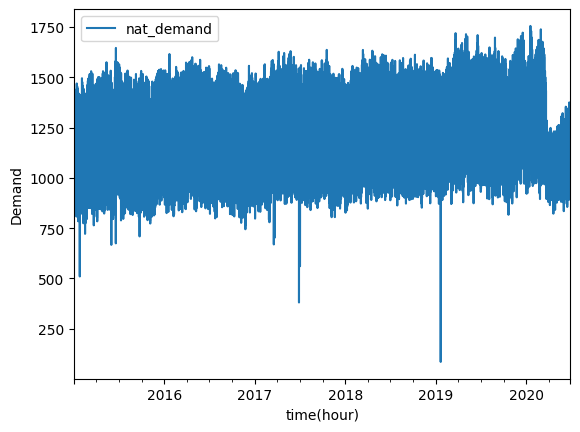

In [24]:
df[['nat_demand']].plot()

plt.xlabel('time(hour)')
plt.ylabel('Demand')

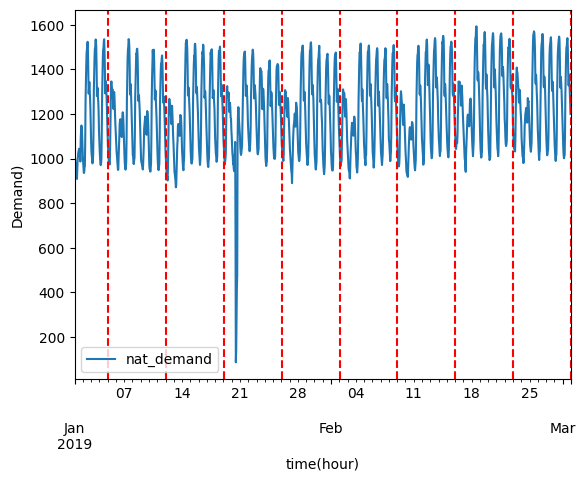

In [25]:

df[['nat_demand' ]]['2019-01-01': '2019-03-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Demand)')

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 5:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

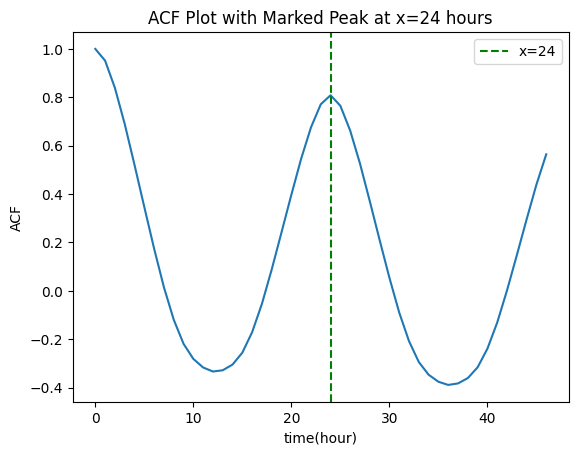

In [27]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
plt.plot(acf(df['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

Interpretation of the ACF Plot
Peak at Lag 24:

* The plot shows a marked peak at a lag of 24 hours.
This indicates a strong autocorrelation at this lag, suggesting that the electricity demand has a daily (24-hour) cycle.
Cyclic Pattern:

* The ACF plot exhibits a sinusoidal pattern, which further confirms the presence of a regular cyclic behavior in the data.
This is typical for electricity demand data, which often follows daily and weekly cycles due to human activities.
Decaying Autocorrelation:

* The autocorrelation starts high at lag 0, decreases, and then increases again to a peak at lag 24.
This indicates that the data points are highly correlated with their values from 24 hours ago, likely due to daily patterns of electricity usage.

                     nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
datetime                                                                    
2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

                       T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  \
datetime                                                                   
2015-01-03 01:00:00  23.482446  0.017272  0.001855  10.328949  22.662134   
2015-01-03 02:00:00  23.399255  0.017265  0.001327  10.681517  22.578943   
2015-01-03 03:00:00  23.343530  0.017211  0.001428  10.874924  22.531030   
2015-01-03 04:00:00  23.238794  0.017128  0.002599  10.518620  22.512231   
2015

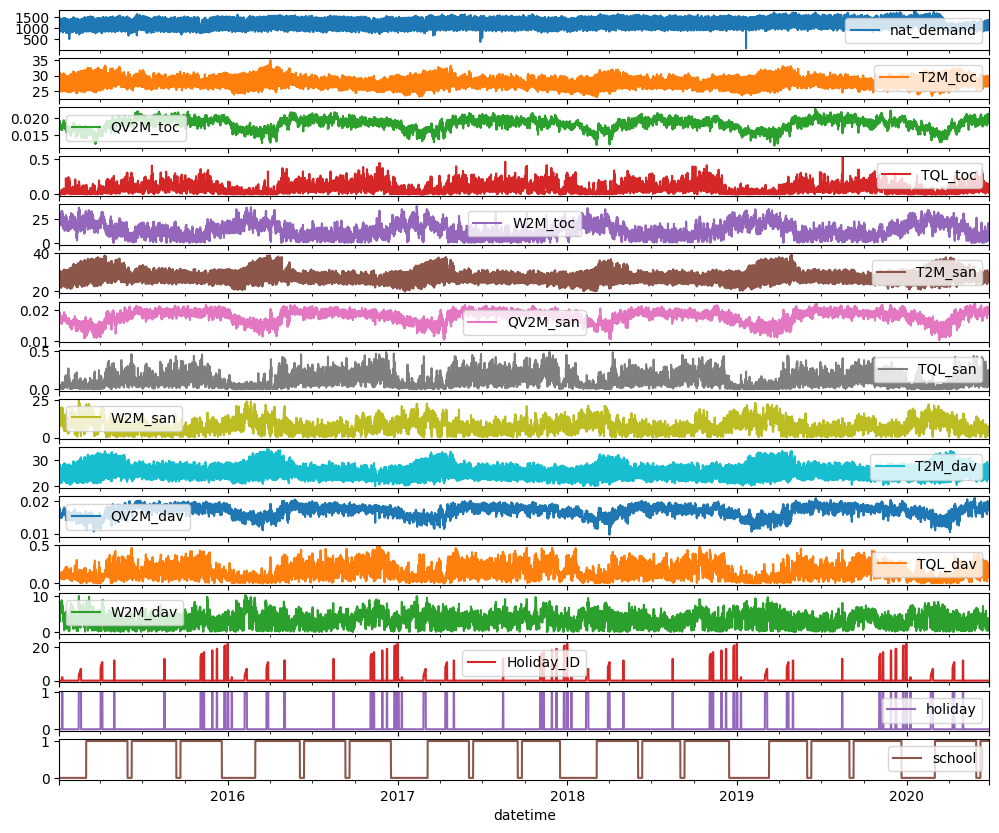

In [4]:
# Inspect the first few rows of the dataset
print(df.head())

# Get a concise summary of the DataFrame
print(df.info())

# Get descriptive statistics of the DataFrame
print(df.describe())

# Check for any missing values
print(df.isnull().sum())

# Visualize the first few rows of the dataset
df.plot(subplots=True, figsize=(12, 10))
plt.show()


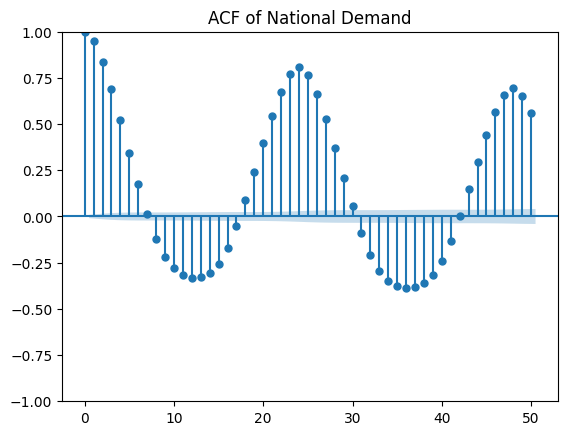

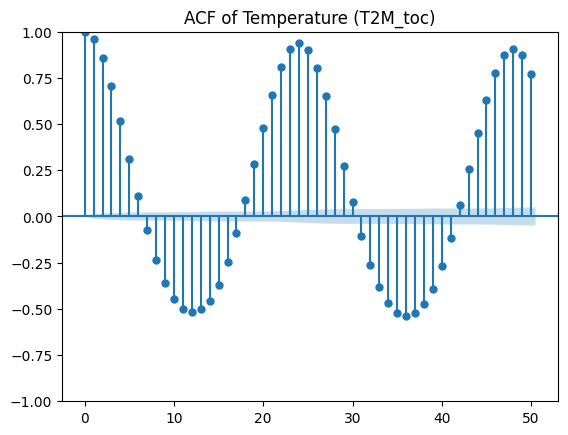

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF for 'nat_demand'
plot_acf(df['nat_demand'], lags=50)
plt.title('ACF of National Demand')
plt.show()

# Plot ACF for other relevant features as needed
# Example for temperature:
plot_acf(df['T2M_toc'], lags=50)
plt.title('ACF of Temperature (T2M_toc)')
plt.show()


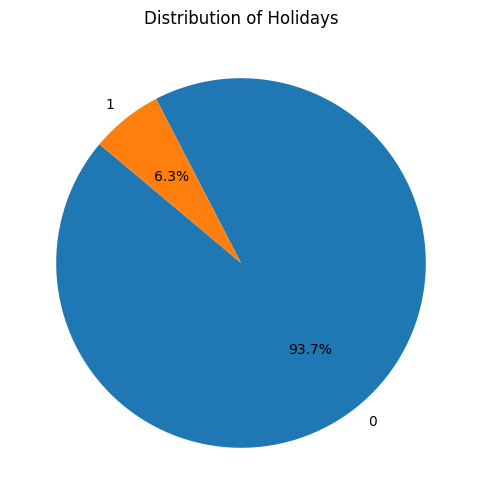

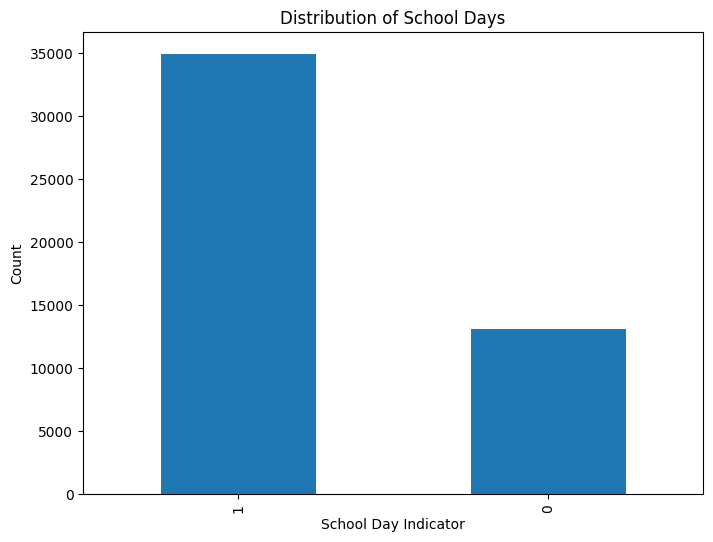

In [6]:
# Example: Pie chart for the distribution of 'holiday' and 'school' days
holiday_counts = df['holiday'].value_counts()
school_counts = df['school'].value_counts()

# Pie chart for holidays
plt.figure(figsize=(8, 6))
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Holidays')
plt.show()

# Bar chart for school days
plt.figure(figsize=(8, 6))
school_counts.plot(kind='bar')
plt.title('Distribution of School Days')
plt.xlabel('School Day Indicator')
plt.ylabel('Count')
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['nat_demand'].dropna())

# Print the test statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -20.96175000729656
p-value: 0.0
Critical Values:
   1%: -3.430486271094305
   5%: -2.861600228969454
   10%: -2.5668020578981667


In [8]:
# Define the split point
train_end = '2019-12-31'
train = df.loc[:train_end]
test = df.loc[train_end:]


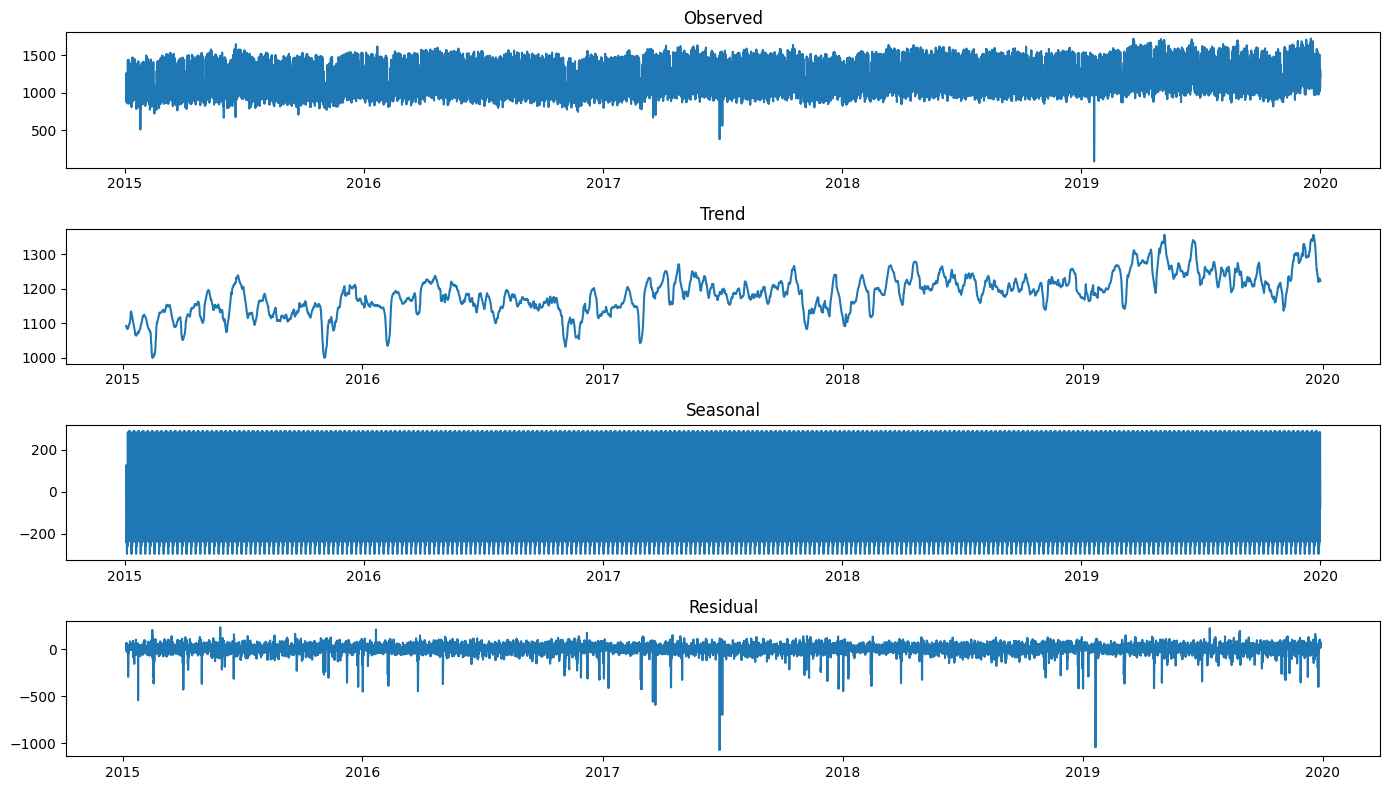

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(train['nat_demand'], model='additive', period=24*7)  # weekly seasonality

# Plot the decomposition
plt.figure(figsize=(14, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()


In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import AutoReg
# Prepare data

seq_length = 24 * 7  # Example sequence length (one week of hourly data)

# Normalize and create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define train-test split
train_size = int(len(df) * 0.8)
train, test = df['nat_demand'][:train_size], df['nat_demand'][train_size:]

# Normalize data for LSTM
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

Exponential Smoothing

In [18]:
# Exponential Smoothing
model_exp = ExponentialSmoothing(train, seasonal='add', seasonal_periods=24*7)
fit_exp = model_exp.fit()
forecast_exp = fit_exp.forecast(steps=len(test))

# Calculate metrics
mse_exp = mean_squared_error(test, forecast_exp)
r2_exp = r2_score(test, forecast_exp)
print(f'Exponential Smoothing - MSE: {mse_exp}, R²: {r2_exp}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Exponential Smoothing - MSE: 16933.560856507705, R²: 0.5104143621006225


In [19]:
# Build and train LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

# Calculate metrics
mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
r2_lstm = r2_score(y_test_inv, y_pred_lstm_inv)
print(f'LSTM - MSE: {mse_lstm}, R²: {r2_lstm}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
LSTM - MSE: 1730.8336678545816, R²: 0.9499352581201578


In [20]:
# Autoregression
model_ar = AutoReg(train, lags=24*7)
fit_ar = model_ar.fit()
forecast_ar = fit_ar.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate metrics
mse_ar = mean_squared_error(test, forecast_ar)
r2_ar = r2_score(test, forecast_ar)
print(f'Autoregression - MSE: {mse_ar}, R²: {r2_ar}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Autoregression - MSE: 17206.117489112665, R²: 0.5025341640744452


In [21]:
# ARIMA
model_arima = ARIMA(train, order=(5, 1, 0))  # Adjust order as needed
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=len(test))

# Calculate metrics
mse_arima = mean_squared_error(test, forecast_arima)
r2_arima = r2_score(test, forecast_arima)
print(f'ARIMA - MSE: {mse_arima}, R²: {r2_arima}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARIMA - MSE: 129870.82704251584, R²: -2.7548447276341426


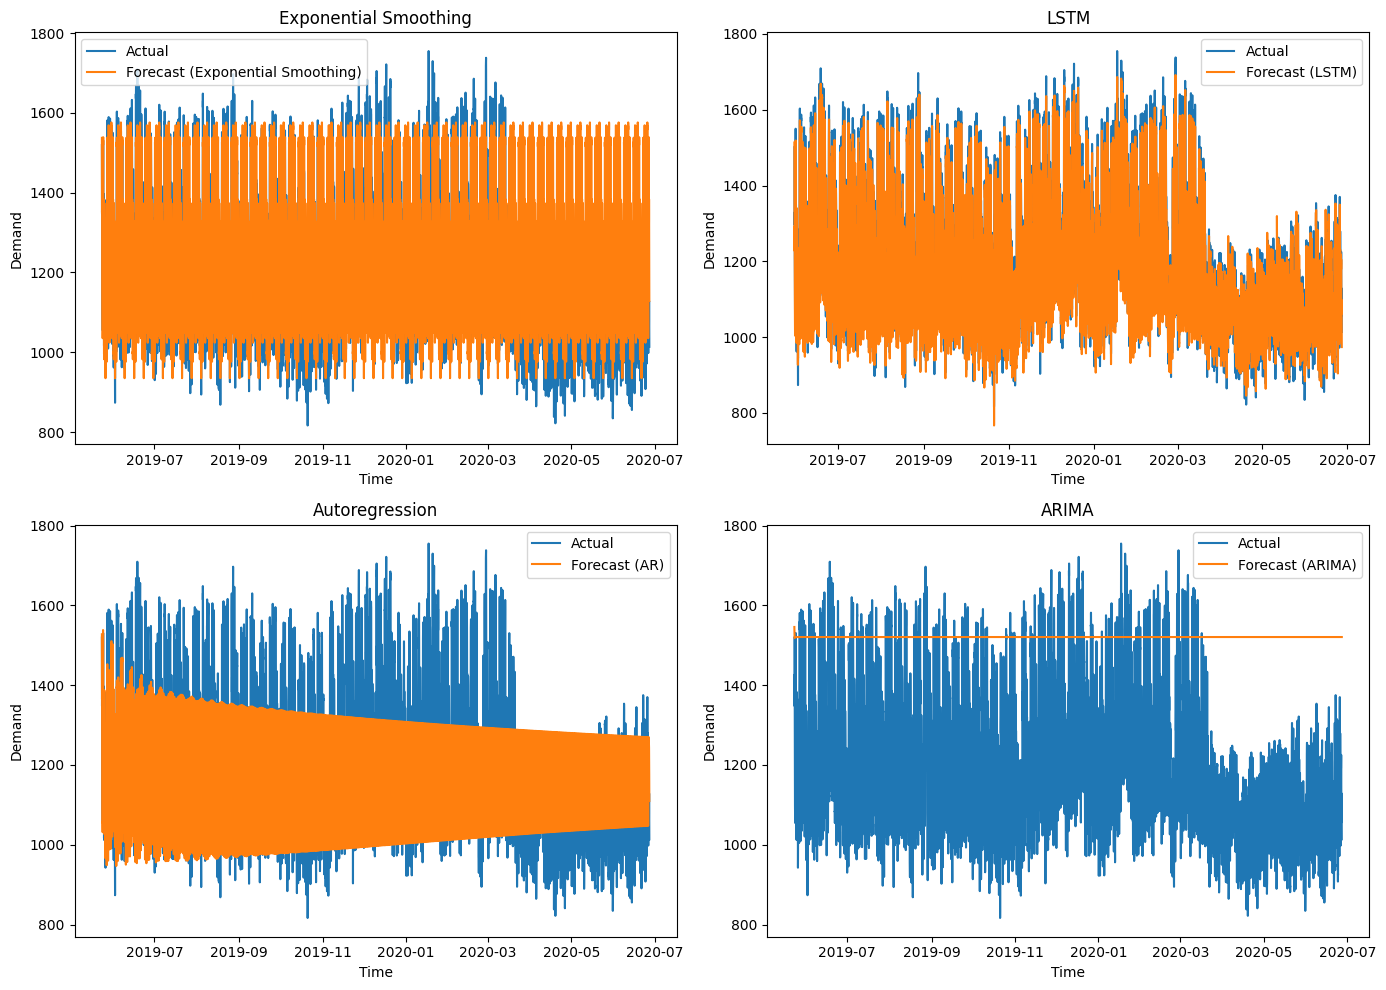

In [22]:
# Plot results
plt.figure(figsize=(14, 10))

# Plot actual vs. forecasted values for Exponential Smoothing
plt.subplot(2, 2, 1)
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_exp, label='Forecast (Exponential Smoothing)')
plt.title('Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Plot actual vs. forecasted values for LSTM
plt.subplot(2, 2, 2)
plt.plot(test.index[seq_length:], y_test_inv, label='Actual')
plt.plot(test.index[seq_length:], y_pred_lstm_inv, label='Forecast (LSTM)')
plt.title('LSTM')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Plot actual vs. forecasted values for Autoregression
plt.subplot(2, 2, 3)
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_ar, label='Forecast (AR)')
plt.title('Autoregression')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Plot actual vs. forecasted values for ARIMA
plt.subplot(2, 2, 4)
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='Forecast (ARIMA)')
plt.title('ARIMA')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

plt.tight_layout()
plt.show()


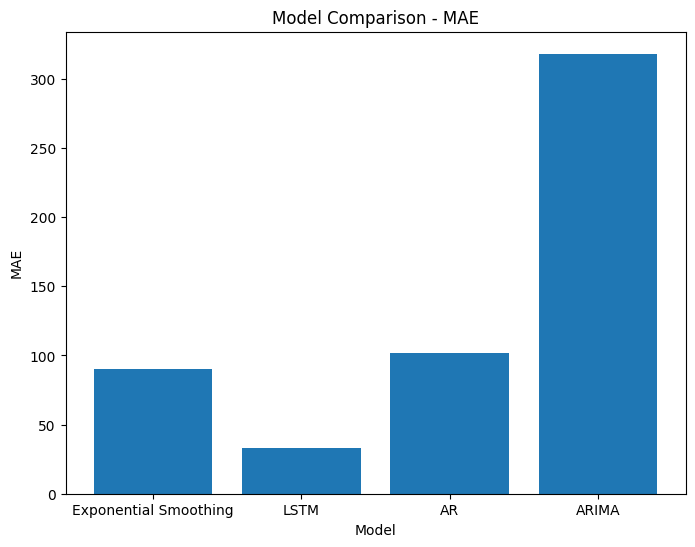

In [23]:
# Compute MAE for each model
mae_exp = np.mean(np.abs(test - forecast_exp))
mae_lstm = np.mean(np.abs(y_test_inv - y_pred_lstm_inv))
mae_ar = np.mean(np.abs(test - forecast_ar))
mae_arima = np.mean(np.abs(test - forecast_arima))

# Plot MAE comparison
plt.figure(figsize=(8, 6))
plt.bar(['Exponential Smoothing', 'LSTM', 'AR', 'ARIMA'], [mae_exp, mae_lstm, mae_ar, mae_arima])
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - MAE')
plt.show()


LSTM runned for 30 mins while others just for 5 sec, that also reflects to the results. With MSE: 1730.8336678545816, R²: 0.9499352581201578 LSTM is just perfoms beastly.